# Prediciting Pneumonia with the help of transfer Learning
This dataset is avilable on Kaggle [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). The motivation for me here was to implement transfer learning. I was doing a tutorial on it, and thought of using a dataset from kaggle and hence this kernal. 

I have tried to explain the model and so, if someone thinks of an improvemnt I can try that. I have used Xception model trained on Imagenet as the base model, and implemented transfer learning in Keras with Tensorflow backend. So, lets start with the dataset and then I will move on to the code:

Its a binary classification dataset. The two classes are **Normal** and **Pneumonia**.  
![Dataset](https://i.imgur.com/jZqpV51.png)


This is taken from https://www.kaggle.com/goelrajat/prediciting-pneumonia-from-chest-xray  and run on kaggle kernal. 


## Import statments
Not much magic here, just routine libraries

In [4]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input
from keras.models import load_model
import keras.callbacks as kcall
import numpy as np
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['chest-xray-pneumonia', 'keras-pretrained-models']


## Reading the dataset direcotry
This is used to understand the dataset distribution. I have also distributed the type of data i.e. training, validation and test for plotting based on class labels. The bash command was taken from [this](https://serverfault.com/a/398682) answer. I tried looping as well but i just couldn't make the code to run. There was some issue with double quotes used in terminal and python returning strings in single quotes.

So for below code, yes I understand its naive but I had to finish this kernal in time and hence couldn't "invest" more time in this small section.

In [5]:
train_NORMAL    = !find ../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/ -type f  -exec file {} \+ | grep -c -i 'image'
train_PNEUMONIA = !find ../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/ -type f  -exec file {} \+ | grep -c -i 'image'
val_NORMAL      = !find ../input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/ -type f  -exec file {} \+ | grep -c -i 'image'
val_PNEUMONIA   = !find ../input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/ -type f  -exec file {} \+ | grep -c -i 'image'
test_NORMAL     = !find ../input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/ -type f  -exec file {} \+ | grep -c -i 'image'
test_PNEUMONIA  = !find ../input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/ -type f  -exec file {} \+ | grep -c -i 'image'


train_data = np.array([int(train_NORMAL[0]),int(train_PNEUMONIA[0])])
test_data = np.array([int(test_NORMAL[0]),int(test_PNEUMONIA[0])])
val_data = np.array([int(val_NORMAL[0]),int(val_PNEUMONIA[0])])

## Plotting the values
The data from above, was used in bar graph below. The plot conveys that we have more example of Pneumonia than that of normal scans, which for me was a bit unexpected. I thought it would be reversed.  

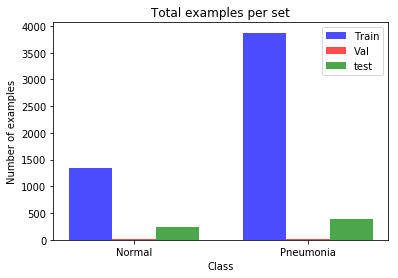

In [6]:
index = np.arange(2)
bar_width = 0.25
opacity = 0.7

rects1 = plt.bar(index, train_data, bar_width,
                alpha=opacity, color='b',
                label='Train')
rects2 = plt.bar(index + bar_width, val_data, bar_width,
                alpha=opacity, color='r', tick_label = ('Normal', 'Pneumonia'),
                label='Val')
rects3 = plt.bar(index + 2*bar_width, test_data, bar_width,
                alpha=opacity, color='g', tick_label = ('Normal', 'Pneumonia'),
                label='test')

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Total examples per set')
plt.xticks(index + bar_width)
plt.legend()

plt.show()

## Parameters
- Learning rate was choosen after training the model couple of time. So, no doubts here
- image width and height was specified as for the base model. 
- batch size, I tried a couple but then stick to 30 as either increasing/decreasing it, wasn't helping in reducing accuracy
- epochs was choosen  because training accuracy reached saturation of around 99.8% and validation accuracy to 100%
- `resume_model` is used when you want to resume from the **compeletly** trained model, i.e. including the last layers inserted by us. 

In [7]:
## Intilizing variables
output_classes = 2
learning_rate = 0.0001
img_width, img_height,channel = 299, 299, 3
training_examples = 5216 
batch_size = 30 
epochs = 5
resume_model = False
training_data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
val_data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'
test_data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
trained_model_dir = '../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Model Defination
Using Xception as the base model, and the reason being, it had the best accuracy on imagenet both Top-1 and Top-5 accuracy. The only thing I tried here was using another layer apart from the final layer. The result was not good and so dropped it in the final model. This code will only be executed is `resume_model` is `False`, and its obivious as well. 

In [8]:
if resume_model == False:
  ## Model Defination
  model = Sequential()
  model.add(Xception(weights=trained_model_dir , include_top=False,pooling = 'avg'))
  #model.add(Dense(units = 100 , activation = 'relu'))
  model.add(Dense(units=output_classes, activation='softmax'))

  model.layers[0].trainable = True

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=learning_rate),
                metrics=['accuracy'])

  ## model.load_weights('xception_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

  ## Image generator function for training and validation
  img_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_img_generator = img_generator.flow_from_directory(
        training_data_dir,
        target_size = (img_width,img_height),
        batch_size = batch_size,
        class_mode = 'categorical')

  val_img_generator = img_generator.flow_from_directory(
                          val_data_dir,
                          target_size = (img_width,img_height),
                          class_mode = 'categorical')

  for i, layer in enumerate(model.layers):
     print('Layer: ',i+1,' Name: ', layer.name)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Layer:  1  Name:  xception
Layer:  2  Name:  dense_1


## CallBacks for model training
This was interesting part, and the only requirment for me was the `LossHistory` class. But, I thought why not extend it and use a couple of more callbacks. Now a word of caution, some callbacks increase the training time because they have their own computation, such as tensorboard. I used in on my mac but not here, because it drastically slowed the training and so i was experimenting here with this data and so its clear not to include tensorboard.

In [9]:
## Callbacks for model training
early_stop = kcall.EarlyStopping(monitor = 'acc', min_delta=0.0001)
tensorboard =kcall.TensorBoard(log_dir='./tensorboard-logs',write_grads=1,batch_size = batch_size)

class LossHistory(kcall.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

history = LossHistory()

## Model Training
I have used generators to provide the images in batches for training, apart from that if you want you can save the model by un-commenting the last line in this block. 

In [10]:
## Training only the newly added layer
if resume_model:
	model = load_model('chest_xray.h5')
else: 
	model.fit_generator(train_img_generator,
        steps_per_epoch = training_examples // batch_size,
        epochs = epochs,
        validation_data = val_img_generator,
		validation_steps = 1,
		callbacks=[early_stop,history])

	## saving model
	#model.save('chest_xray.h5')


Epoch 1/5
173/173 [==============================] - 139s 804ms/step - loss: 0.0986 - accuracy: 0.9649 - val_loss: 0.1515 - val_accuracy: 1.0000
Epoch 2/5


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


173/173 [==============================] - 126s 726ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0688 - val_accuracy: 1.0000
Epoch 3/5
173/173 [==============================] - 126s 726ms/step - loss: 0.0172 - accuracy: 0.9950 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/5
173/173 [==============================] - 125s 725ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.1222 - val_accuracy: 0.8750
Epoch 5/5
173/173 [==============================] - 125s 725ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1545 - val_accuracy: 0.9375


## Test image generator
Now if you have read, genrative models, then its not actually generating images, rather this function here acts as a pipeline to provide the images as batches for the model evaluation step. 
- Shuffle here is `False` because I read it somewhere to set it so when evaluating the model
- `Batch_size` is same as that used in training the model

In [11]:
## Image generator function for testing
test_img_generator = img_generator.flow_from_directory(
                        test_data_dir,
                        target_size = (img_width,img_height),
                        class_mode = 'categorical',
                        batch_size= batch_size,
			                  shuffle = False)

Found 624 images belonging to 2 classes.


## Evaluating the model
This step is used to evaluate the model. It takes the image "generator" to provide images in batch and if you have question on steps then dont worry its mentioned in Keras documentation.

In [12]:
test_accu = model.evaluate_generator(test_img_generator,steps=624 // batch_size)

## Declaring results
- Loss on Test data  
- Accuracy on Test data

In [13]:
print('Accuracy on test data is:', test_accu[1])
print('Loss on test data is:', test_accu[0])

Accuracy on test data is: 0.7933333516120911
Loss on test data is: 7.671802450204268e-05


## Data Visualisation
Below are 2 plots, namely Training loss vs batches trained and the other one is trainng accuracy vs batches trained. I am new to platform and to machine learning as well, so these are only two plots which came to my mind.

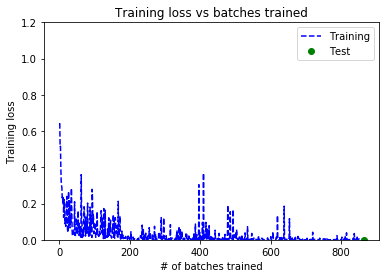

In [14]:
plt.plot(history.losses,'b--',label='Training')
plt.plot(len(history.losses)-1,test_accu[0],'go',label = 'Test')

plt.xlabel('# of batches trained')
plt.ylabel('Training loss')

plt.title('Training loss vs batches trained')

plt.legend()

plt.ylim(0,1.2)
plt.show()

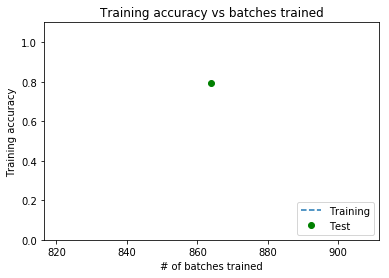

In [15]:
plt.plot(history.acc,'--',label= 'Training')
plt.plot(len(history.acc)-1,test_accu[1],'go',label='Test')

plt.xlabel('# of batches trained')
plt.ylabel('Training accuracy')

plt.title('Training accuracy vs batches trained')

plt.legend(loc=4)
plt.ylim(0,1.1)
plt.show()